# Projet de mathématiques

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import copy as cp
from __future__ import division
import os

In [22]:
#psi = ondelette "mère"
#1 entre 0 et 1/2, -1 entre 1/2 et 1, zero sinon
def Psi(t):
    if t>=0 and t<0.5 :
        return(1)
    elif t>=0.5 and t<1 :
        return(-1)
    else :
        return(0)
vPsi=np.vectorize(Psi) #rend la fonction applicable à un vecteur

# On implémente les ondelettes de la base
# u corresond au décalage temporel et s à l'écrasement de l'ondelette
# t au pas de temps, on peut entrer un vecteur de temps
def psi(u,s,t):
    if s!=0 :
        return(vPsi((t-u)/s)/np.sqrt(s))
    else :
        #print("warning division par zero, ondelette remplacée par fonction nulle")  
        return(np.zeros(t.size))
    
#matrice de la base
def base(timeStamps,decalage,dilatation):
    B=np.zeros((decalage.size,dilatation.size,timeStamps.size))
    for i in range(decalage.size):
        for j in range(dilatation.size):
            B[i,j,:]=psi(decalage[i],dilatation[j],timeStamps)
    return(B)



In [23]:
class Wavelet(object):
    def __init__(self, timeStamps,function,decalage,dilatation):
        baseDecomposition=base(timeStamps,decalage,dilatation)
        self.coefficients=np.divide(np.dot(cp.deepcopy(baseDecomposition),function(timeStamps)),np.transpose(np.meshgrid(U,S)[1])**2)
        self.approximation=np.sum(np.sum(np.multiply(cp.deepcopy(baseDecomposition),np.reshape(cp.deepcopy(self.coefficients),(decalage.size,dilatation.size,1))),axis=0),axis=0)
    

## A une dimension

### Transformation et transformation inverse

In [24]:
# j tel que le vecteur à transformer soit de taille 2**j

In [25]:
## Matrice de Transformation
def Matrice1D(j):
    ### donne la matrice permettant d'effectuer la transformation d'un vecteur 1D de longueur 2**j
    L=np.zeros((2**(j),2**(j)))
    L[0,:]=2**(-j)
    
    for i in range(1,j+1):
        for k in range(2**(i-1)):
        
            L[k+2**(i-1),k*2**(j-i+1):k*2**(j-i+1)+2**(j-i)]=2**(i-j-1)
            
            L[k+2**(i-1),k*2**(j-i+1)+2**(j-i):(k+1)*2**(j-i+1)]=-2**(i-j-1)
            
    return (L)

## On effectue la transformation
def Transformation1D(vecteur):
    ### Effectue la transformation en ondelettes d'un vecteur
    ### vérification que la longueur peut être en taille 2**j
    ### raccourcir la matrice si nécessaire
    j=int(np.log2(vecteur.size))
    if vecteur.size !=2**j :
        vecteur=vecteur[0:2**j]
    
    return(np.dot(Matrice1D(j),vecteur.T))

## Inverse de la transformation
def Inverse1D(transformation,level=[],invMatrix=[],where=[]):
    ### Give the inverse transformation in 1D for a vector of coefficient of size
    ### n=2**j
    ### If the vector is not is this format, it is truncated to fit
    ###
    ### level corresponds to the level of recomposition
    ### i.e. until which level of detail we want to compute the recomposition
    ### level must be an integer in [0,j]
    ### if it is not set or has an incorrect value, the maximum level of recomposition (j)
    ### is chosen by default
    ###
    ### if invMatrix is not given, it is computed as the inverse of the transformation matrix
    ### corresponding to the wanted level of computation
    ### this allow to explicitly compute the inverse matrix and spare some computation
    j=int(np.log2(transformation.size))

    if type(level)!=int or level>j :
        level=j
    
    if len(where)==0:
        where=np.ones(2**level,dtype=bool)
    
    if 2**j!=transformation.size or j!=level :
        print('Vecteur tronqué')
        transformation=transformation[0:2**level]
        
    if len(invMatrix)==0 :
        invMatrix=np.linalg.inv(Matrice1D(level))

    
    return(np.dot(invMatrix[where,:],transformation))

## Si on choisit de s'arrêter à un niveau de décomposition,
## cette fonction permet plotter la transformation, qui n'a
## pas la même taille que le vecteur initial de manière plus commode
def Dedoublage(x,y,where=[]):
    ### on divise par deux le nombre d'éléments dans le vecteur à chaque simplification
    ### du niveau de décomposition
    ### on répète donc les différents éléments pour avoir quelquechose
    ### de plotable avec x en abcisse
    
    # niveauSimplification = j-level
    niveauSimplification=int(np.log2(x.size/y.size))
    
    if len(where)==0:
        where=np.ones(x.size,dtype=bool)
    
    Y=np.repeat(y,2**niveauSimplification)
    return(Y[where])
    
    
    

### Exemple sur une fonction

#### Fonction considérée et transformation

In [26]:
## Définition de la fonction
def f(x):    
    return(np.sqrt((np.cos(2*np.pi*x))**2))

## Application à une gamme de valeurs
j=8
start=0
step=0.01
# vecteur d'abcisse
x=np.arange(start,start+step*2**j,step)
# on vérifie que la longueur est une puissance de 2
print(x.size)

y=f(x)

# Transformation
coeff=Transformation1D(y)

256


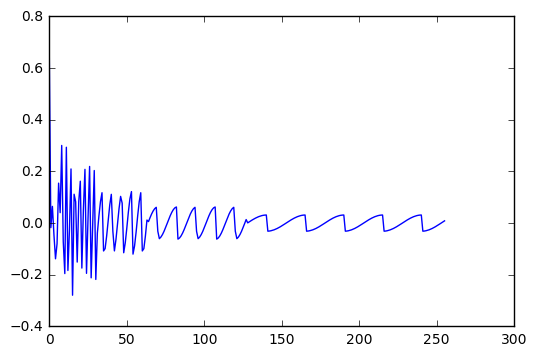

In [27]:
plt.figure()
plt.plot(coeff)
plt.show()

On obtient des valeurs importante dans ce qui correspond aux gammes de fréquences majeures de la fonction.

#### Reconstruction sans perte

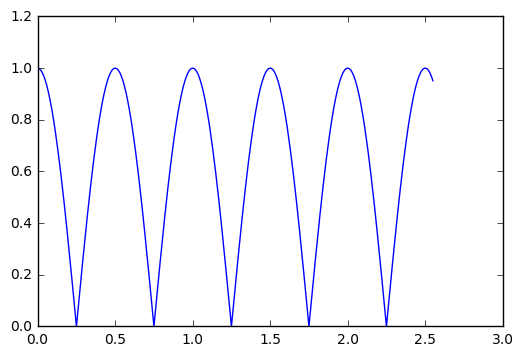

In [28]:
#transformation inverse
inv=Inverse1D(coeff)           

#plot
plt.figure()
plt.plot(x,inv)
plt.show()

#### Reconstruction en s'arrêtant à un certain niveau de recomposition
Analogue à un downsampling en remplaçant des groupes de valeurs par leur moyenne

Vecteur tronqué


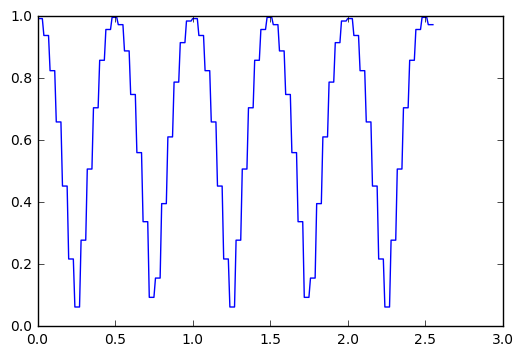

In [29]:
# Ici le vecteur est de taille 2**8
# On effectue la transformation en divisant par quatre = 2**2
# la taille de l'output
# On choisit donc level tel que log2(taille)-level=2
# Soit level = 6

invLevel6=Inverse1D(coeff,level=6)           
invGoodSize=Dedoublage(x,invLevel6)

plt.figure()
plt.plot(x,invGoodSize)
plt.show()

#### Reconstruction en supprimant les coefficients presque nuls

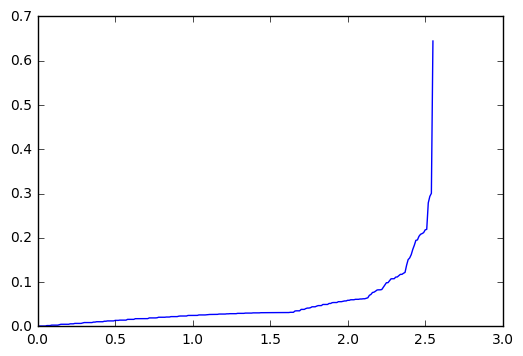

In [30]:
sortedCoeff=np.sort(np.abs(coeff))
plt.figure()
plt.plot(x,sortedCoeff)
plt.show()

On ne conserve que la fraction "residu" des coefficients.
On ne garde que ceux dont la valeur absolue est la plus forte.

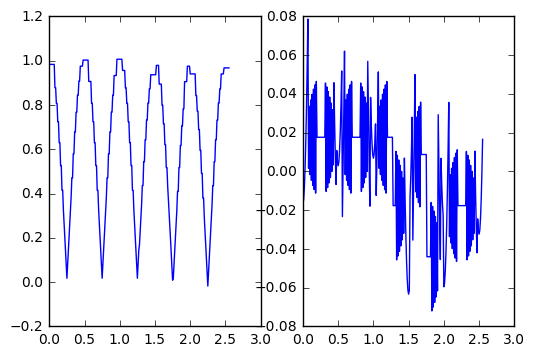

In [31]:
residu=0.5
threshold=sortedCoeff[int(residu*coeff.size)]
cutCoeff=coeff
cutCoeff[np.abs(cutCoeff)<threshold]=0
invSimplified=Inverse1D(cutCoeff)

plt.figure()
plt.subplot(121)
plt.plot(x,invSimplified)
plt.subplot(122)
plt.plot(x,invSimplified-y)
plt.show()

#### Reconstruction sur un intervalle
A revoir !!

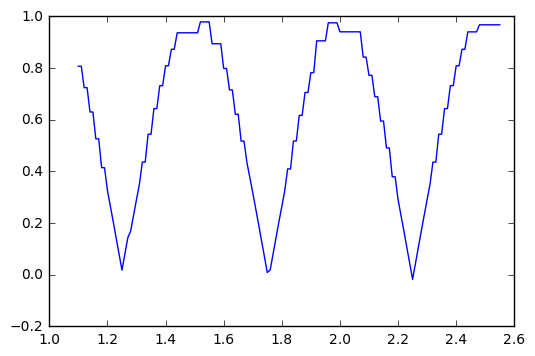

In [32]:
intervalle=x-1>0.1
invPartiel=Inverse1D(coeff,where=intervalle)
plt.figure()
plt.plot(x[intervalle],invPartiel)
plt.show()

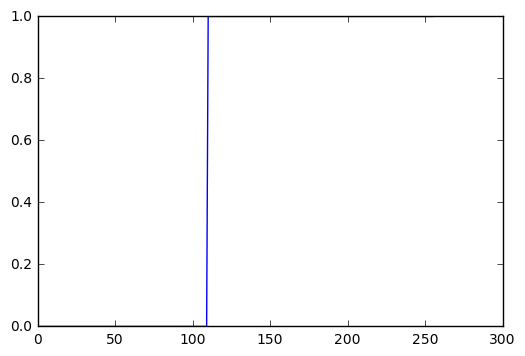

In [33]:
intervalle=x-1>0.1
plt.figure()

plt.plot(intervalle)
plt.show()

## En dimension 2

### Décomposition

In [34]:
def Operation2D(h,T=np.array([[1.,-1.,1.,-1.],[1.,1.,-1.,-1.],[1.,-1.,-1.,1.],[0.25,0.25,0.25,0.25]])):
    return(np.dot(T,h.reshape(4).T))



def Transfohaar2(image):
    def Operation2D(h,T=np.array([[1.,-1.,1.,-1.],[1.,1.,-1.,-1.],[1.,-1.,-1.,1.],[0.25,0.25,0.25,0.25]])):
        return(np.dot(T,h.reshape(4).T))
    
    #taille matrice
    J=min(image.shape[0],image.shape[1])
       
    #calcul de la puissance de 2 de la taille de la matrice
    K=int(np.log2(J))
    if 2**K!=J:
        # Si la matrice n'est pas carré de côté de longueur une puissance de 2,
        # on coupe la matrice pour ne garder que la plus grande sous matrice
        # répondant à ce critère
        print('Matrice tronquée')
        image=image[0:2**K,0:2**K]
    #matrice des coefficients
    L=np.zeros(image.shape)
    
    #matrice des moyennes résiduelles sur laquelle on effectue les opération et qu'on
    #actualise à chaque itération
    P=cp.copy(image)
    # on boucle sur les niveaux de décomposition, il y en a log2(taille matrice)
    for i in range(K):
    # boucle sur les niveaux de décomposition
        # matrice provisoire avec les moyennes
        # on stocke les détails dans L et les résidus (moyenne) dans H avant de réeffectuer l'opération
        exposantH=K-i-1
        # H sera la matrice des moyenne qu'on actualise
        H=np.zeros((2**exposantH,2**exposantH))
        
        for j in range(0,2**exposantH+1,2):
            for k in range(0,2**exposantH+1,2):
                #(j,k)= boucle sur les sous-matrices 2x2 de P
                # décomposition de chacune des sous-matrices 2x2
                b=Operation2D(P[j:j+2,k:k+2])
                # attribution des détails à la sous matrice de L correspondant
                L[j/2,J/(2)**(i+1)+k/2]=b[0]
                L[J/(2)**(i+1)+j/2,J/(2)**(i+1)+k/2]=b[1]
                L[J/(2)**(i+1)+j/2,k/2]=b[2]
                # actualisation de la matrice des moyennes
                H[j/2,k/2]=b[3]
        P=H
    # à la fin on obtient comme coefficient de moyenne la moyenne de l'image
    # on la met à la premiere place de L
    L[0,0]=b[3]
    return(L)

In [35]:
def Oper2D(h,T=np.array([[0.25,0.25,0.25,0.25],[1.,-1.,1.,-1.],[1.,1.,-1.,-1.],[1.,-1.,-1.,1.]])):
    return(np.dot(T,h.reshape(4).T))


def f2D(j):
# donne le sous cube dans la matrice de détail
    a=np.array([int(j>1),int(j%2==1)])
    return(a) 

def Decomposition2D(P,name):
### Effectue une décomposition itérative de P
### Name doit être un str et P un array de dimension 2
### Les coefficients (détails) seront stockés dans la variable globale nommée 'name'
### P stocke les moyennes résiduelles du niveau de décomposition où l'on se trouve
### Tant qu'on n'est pas au dernier niveau de décomposition,
### càd que P n'est pas un nombre unique correspondant à la moyenne de toute la matrice,
### P est actualisé à chaque itération.
### Lorsque l'on est arrivé au dernier niveau, la fonction s'arrête


    gbl=globals()
               
    i=int(np.log2(P.shape[0]))
    if i==0 :
        gbl[name][0,0]=P[0,0]
    else :            
        H=np.zeros((2**(i-1),2**(i-1)))
        for x in range(2**(i-1)):
            for y in range(2**(i-1)):
                b=Oper2D(P[2*x:2*(x+1),2*y:2*(y+1)])
                H[x,y]=b[0]
                for j in range(1,4):
                    a=f2D(j)
                    gbl[name][a[0]*2**(i-1)+x,a[1]*2**(i-1)+y]=b[j]
        Decomposition2D(H,name)


def Haar2(image,name='L'):


    #taille matrice
    J=min(image.shape[0],image.shape[1])
       
    #calcul de la puissance de 2 de la taille de la matrice
    K=np.log2(J)
    if 2**K!=J:
        # Si la matrice n'est pas carré de côté de longueur une puissance de 2,
        # on coupe la matrice pour ne garder que la plus grande sous matrice
        # répondant à ce critère
        print('Matrice tronquée')
        image=image[0:2**K,0:2**K]

    # gestion du nom voulu pour l'output
    name=str(name)
    gbl=globals()
    
    #matrice des coefficients
    gbl[name]=np.zeros(image.shape)
    #matrice des moyennes résiduelles sur laquelle on effectue les opération et qu'on
    #actualise à chaque itération
    
    P=cp.copy(image)
    Decomposition2D(P,name)
    print("My work is over")

### Recomposition

In [36]:
np.linalg.inv(np.array([[1.,-1.,1.,-1.],[1.,1.,-1.,-1.],[1.,-1.,-1.,1.],[0.25,0.25,0.25,0.25]]))

array([[ 0.25,  0.25,  0.25,  1.  ],
       [-0.25,  0.25, -0.25,  1.  ],
       [ 0.25, -0.25, -0.25,  1.  ],
       [-0.25, -0.25,  0.25,  1.  ]])

In [37]:
def OperationInverse2D(v,I=np.array([[0.25,0.25,0.25,1],[-0.25,0.25,-0.25,1],[0.25,-0.25,-0.25,1],[-0.25,-0.25,0.25,1]])):
### Fait le produit matriciel entre le vecteur à recomposer contenant détails et moyennes et la ### matrice de recomposition. Renvoie les 4 niveaux de détail suivant. 
    return(np.dot(I,v.T).reshape((2,2)))

def transfohaar2Inv(coeff2D,level=[]):
### Prend la decomposition et renvoie image recomposee. 
### Prend en entree une matrice carree de dimension 2^n.
### A chaque niveau de recomposition, une matrice est cree pour stocker toutes les moyennes 
### nécessaires à la reconstruction des niveaux de détail suivants. 
 
    #taille matrice
    J=coeff2D.shape[0]

    # matrice des opérations
    # on commence avec P une matrice 2D avec la moyenne de l'image comme premier élément
    P=np.array([[coeff2D[0,0],0],[0,0]])

    k=int(np.log2(J))        
    if 2**k!=J or len(coeff2D.shape)!=2:
        print('matrice de coefficients sous un mauvais format !')
    
    # choix du niveau de recomposition, par défaut maximum
    if type(level)!=int or level>k or level<0 :
        level=k
    
    for i in range(level):
        H=np.zeros((2**(i+1),(2)**(i+1)))
        for m in range(2**i):
            for l in range(2**i):
                h=OperationInverse2D(np.array([coeff2D[l,m+2**(i)],coeff2D[l+2**(i),m],coeff2D[l+2**(i),m+2**(i)],P[l,m]]))
                H[2*l:2*l+2,2*m:2*m+2]=cp.copy(h)
        P=cp.copy(H)
    return(P)


#### unfinished
#### Parfaitement équivalent à ci-dessus mais avec une fonction s'appelant de manière récursive

def OperationInv2D(v,I=np.array([[1,0.25,0.25,0.25],[1,-0.25,0.25,-0.25],[1,0.25,-0.25,-0.25],[1,-0.25,-0.25,0.25]])):
### Fait le produit matriciel entre le vecteur à recomposer contenant détails et moyennes et la ### matrice de recomposition. Renvoie les 4 niveaux de détail suivant. 
    return(np.dot(I,v.T).reshape((2,2)))



def f2D(j):
# donne le sous cube dans la matrice de détail
    a=np.array([int(j>1),int(j%2==1)])
    return(a) 

def Recomposition2D(Coeff2D,name,niveau):
### Effectue une recomposition itérative de P
### Name doit être un str et P un array de dimension 2

    gbl=globals()

    J=gbl[name].shape[0]
    I=int(np.log2(J))

    if I!=niveau:
        for x in range(2**(niveau)):
            for y in range(2**(niveau)):
                moy=gbl[name][x*2**(I-niveau),y*2**(I-niveau)]
                d1=Coeff2D[2**(niveau)+x]
                d2=Coeff2D[]
                d3=Coeff2D[]
                a=OperationInverse2D(np.array([moy,d1,d2,d3]))
        

                gbl[name][x*2**(I-niveau):(x+1)*2**(I-niveau),y*2**(I-niveau):(y+1)*2**(I-niveau)]=
    

    
    
    
                        b=Operation2D(P[2*x:2*(x+1),2*y:2*(y+1)])
                        H[x,y]=b[0]
                        for j in range(1,4):
                            a=f2D(j)
                            gbl[name][a[0]*2**(i-1)+x,a[1]*2**(i-1)+y]=b[j]
    
    
        Recomposition2D(Coeff2D,name,niveau+1)


def Recomposition2(coeff2,name='L',level=[]):


    #taille matrice
    J=min(coeff2.shape[0],coeff2.shape[1])
       
    #calcul de la puissance de 2 de la taille de la matrice
    K=np.log2(J)
    if 2**K!=J or coeff2.shape[0]!=coeff2.shape[1]:
        print('coeff au mauvais format')
        return(False)
    
    if type(level)!=int or level>K or level<0 :
        level=K
    # on supprime les coefficients inutiles    
    coeff2=coeff2[0:2**level,0:2**level]

    # gestion du nom voulu pour l'output
    name=str(name)
    gbl=globals()
    
    #reconstruction qui va être améliorée à chaque iteration de recomposition
    gbl[name]=np.ones((2**level,2**level))*coeff2[0,0]
    # On effectue la resonstitution jusqu'au rang 
    Recomposition2D(coeff2,name,0)
    print("My work is over")

### Partial Recomposition

In [38]:
def start(coord):
    a=np.zeros(2,dtype=int)
    A=coord.shape[0]
    for i in range(A):
        where=f2D(coord[i])
        a[0]=a[0]+where[0]*2**A
        a[1]=a[1]+where[1]*2**A
        A=A-1
    return(a)

def actualize(coefficients,w,moyenne):
    ### w = coordonnées [x,y], x et y dans [0,1]
    ### des coefficiencts à conserver
    
    size=int(np.log2(coefficients.shape[0]))-1
    if size==-1:
        print('erreur dans actualize, coefficients donnés de taille 1')
        return(False)
    actualise=np.zeros((2**(size),2**(size)))
    actualise[0,0]=moyenne
    for i in range(0,size):
        block=2**(i+1)
        subBlock=2**(i)
        for j in range(1,4):
            C=f2D(j)
            x=C[0]
            y=C[1]
            actualise[x*subBlock:(x+1)*subBlock,y*subBlock:(y+1)*subBlock]=coefficients[x*block+w[0]*subBlock:x*block+(w[0]+1)*subBlock,y*block+w[1]*subBlock:y*block+(w[1]+1)*subBlock]
    return(actualise)  
    

In [39]:
print(np.amin(Im))
print(np.amax(Im))

NameError: name 'Im' is not defined

In [ ]:
def portion1D(coefficients,coord):
    ### Retourne la décomposition de l'image en ne calculant
    ### que les niveaux de détails nécessaires à la reconstruction
    ### de la sous-matrice dont les coordonnées sont données par coord
    ###
    ### name (str) est le nom de la variable où écrire le résultat
    ###
    ### Les coordonnées doivent être données sous la forme d'un arbre
    ### A chaque niveau, on n'effectuera la décomposition que du carré
    ### indiqué par le numéro dans coord
    ### 0 en haut à g, 1 en h à d, 2 en b à g, 3 en b à d
    ### On choisit ainsi son chemin successivement à chaque niveau
    ### lorsque l'on arrive au bout de coord, tout les niveaux de détails
    ### disponibles du bloc dans lequel on se trouve sont reconstruits
    A=coord.shape[0]
    J=coefficients.shape[0]
    K=int(np.log2(J))
    output=transfohaar2Inv(coefficients,level=1)
    # H est la matrice des coefficients qui sera actualisée à chaque itération
    H=np.copy(coefficients)
    
    if A>J-1:
        coord=coord[0:J-1]
        A=J-1
    coord[coord<0]=0
    coord[coord>3]=3
    ############################################
    for i in range(A):
        k=int(np.log2(output.shape[0]))
        
        # conversion du pas suivant en coordonnées
        pasSuivant=coord[i]
        chemin=f2D(pasSuivant)
        # récupération de la moyenne d'intérêt
        carre=transfohaar2Inv(H[0:2,0:2],level=1)        
        moyenne=carre[chemin[0],chemin[1]]
        # on met les moyennes calculées dans output
        output=np.repeat(np.repeat(output,2,axis=0),2,axis=1)
        emplacement=start(coord[0:i+1])
        output[emplacement[0]:emplacement[0]+2,emplacement[1]:emplacement[1]+2]=carre
        fig=plt.figure()
        ax=fig.add_subplot(111)
        plt.imshow(output,interpolation="nearest",vmin=367,vmax=2157)
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        plt.savefig(r'partial'+str(i)+r'.pdf')
        plt.clf()
        # actualisation des coefficients selon chemin
        H=actualize(H,chemin,moyenne)        
        
    # decomposition maximale de ce qui reste
    residu=K-A
    cheminFinal=start(coord)*2**(residu-1)
    decompFinale=transfohaar2Inv(H)
    output=np.repeat(np.repeat(output,2**(residu-1),axis=0),2**(residu-1),axis=1)
    output[cheminFinal[0]:cheminFinal[0]+2**residu,cheminFinal[1]:cheminFinal[1]+2**residu]=decompFinale
    return(output)
        

In [ ]:
A=np.arange(1024).reshape((32,32))
Haar2(A,name='B')

In [ ]:
plt.figure()
plt.imshow(A,interpolation="nearest")
plt.show()

In [ ]:
plt.figure()
plt.imshow(B,interpolation="nearest")
plt.show()

In [ ]:
C=portion1D(B,np.array([2,0,1]))

In [ ]:
plt.figure()
plt.imshow(C,interpolation="nearest")
plt.show()

### Application

#### Création de l'image

In [ ]:
# Get the numbefs of the images in the directory

##Path selection
path=r"C:\Users\Romain\Documents\cours\M1\info\scripts\scripts-161215-pywavelets\BrainZebrafish-stack"
os.chdir(path)

##getting the numbers of the images
directoryContent=os.listdir(path)
imageName=directoryContent[0]
print(imageName)

numberStart=16
numberEnd=-4
imageName[numberStart:numberEnd]

for i in range(len(directoryContent)) :
    directoryContent[i]=int(directoryContent[i][16:-4])
directoryContent=np.array(directoryContent)
directoryContent=np.sort(directoryContent)

In [ ]:
startImage=1000 #name in the directory
nImages=160
zSize=40

startIndex=int(np.where(directoryContent==startImage)[0])

if len(directoryContent)<startIndex+nImages :
    print('Warning index out of range')
    
## Preallocation
#select the first image
image=plt.imread(imageName[0:16]+str(startImage)+imageName[-4:])

In [ ]:
Im=image[76:588,230:742]

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(Im)
plt.show()

#### Transformation et reconstruction

In [ ]:
Haar2(Im,'coeff2D')

In [ ]:
plt.figure()
plt.imshow(coeff2D)
plt.show()

In [ ]:
plt.figure()
plt.imshow(np.abs(coeff2D)>10)
plt.show()

In [ ]:
ImInv=transfohaar2Inv(coeff2D,level=9)
plt.figure()
plt.imshow(ImInv)
plt.show()

#### Différents niveaux de reconstruction

In [ ]:
plt.figure()
for i in range(2,10):
    plt.subplot(330+i)
    plt.imshow(transfohaar2Inv(coeff2D,level=i))
    plt.show()

#### Suppression des plus faibles coefficients

In [ ]:
print(coeff2D.shape)
plt.figure()
plt.plot(np.sort(coeff2D.reshape(coeff2D.shape[0]*coeff2D.shape[1])))
plt.show()

In [ ]:
path=r'C:\Users\Romain\Documents\cours\M1\info\iterations'
for i in range(1,10):
    size=2**i
    fig=plt.figure()
    ax=fig.add_subplot(111)
    plt.imshow(transfohaar2Inv(coeff2D,level=i),interpolation="nearest",vmin=367,vmax=2157)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.title(r'Niveau='+str(i)+r' taille='+str(2**i))
    plt.savefig(r'reconstruction2DLevel'+str(i)+r'.pdf')  
    #plt.show()
    plt.clf()

In [ ]:
np.amin(coeff2D),np.amax(coeff2D)

In [ ]:
sum(sum(np.abs(coeff2D<100)))/(coeff2D.shape[0]*coeff2D.shape[1])

In [ ]:
simplifiedCoeff2D=cp.copy(coeff2D)
simplifiedCoeff2D[np.abs(simplifiedCoeff2D)<100]=0
simplifiedImInv=transfohaar2Inv(simplifiedCoeff2D)
plt.figure()
plt.subplot(121)
plt.imshow(ImInv)
plt.subplot(122)
plt.imshow(simplifiedImInv)
plt.show()

In [ ]:
plt.figure()
plt.imshow(simplifiedCoeff2D!=0)
plt.show()

#### Suppression des niveaux de décomposition les plus bas

In [ ]:
coeff2D.shape

In [ ]:
highPassFiltered=coeff2D
highPassFiltered[0:coeff2D.shape[0]//16,0:coeff2D.shape[1]//16]=0
highPassFilteredInv=transfohaar2Inv(highPassFiltered)
plt.figure()
plt.subplot(121)
plt.imshow(highPassFilteredInv)
plt.subplot(122)
plt.imshow(highPassFilteredInv>10)
plt.show()

#### Recomposition d'une zone

In [ ]:
path=r'C:\Users\Romain\Documents\cours\M1\info\partial'
os.chdir(path)
partialIm=portion1D(coeff2D,np.array([2,1,0,0]))
partialIm[0,0]=np.amax(Im)
fig=plt.figure()
ax=fig.add_subplot(111)
plt.imshow(partialIm,interpolation="nearest",vmin=367,vmax=2157)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.savefig(r'partialTotal.pdf')
plt.clf()

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(Im)
plt.subplot(122)
plt.imshow(partialIm)
plt.show()

## En 3D

In [ ]:
T3D=np.array([[0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125],[1,1,1,1,-1,-1,-1,-1],[1,1,-1,-1,1,1,-1,-1],[1,1,-1,-1,-1,-1,1,1],[1,-1,1,-1,1,-1,1,-1],[1,-1,1,-1,-1,1,-1,1],[1,-1,-1,1,-1,-1,1,1],[1,-1,-1,1,-1,1,1,-1]])
I3D=np.linalg.inv(T3D)
print(I3D)

In [ ]:
np.array([[1.,0.125,0.25,0.,0.125,0.125,0.25,0.], [1.,0.125,0.,0.25,-0.125,-0.125,-0.25,0.],[1.,0.125,-0.25,0.,0.125,0.125,-0.25,0.],[1.,0.125,0.,-0.25,-0.125,-0.125,0.25,0.,],[ 1.,-0.125,0.25,-0.25,0.125,-0.125,0.25,-0.25], [1.,  -0.125, 0.  ,  0.  ,  -0.125,  0.125 ,-0.25 ,  0.25 ],[ 1. ,   -0.125 ,-0.25 ,  0.25,   0.125, -0.125, -0.25  , 0.25 ],[ 1.  ,  -0.125,  0.  ,   0.  ,  -0.125,  0.125 , 0.25  ,-0.25 ]])

### Décomposition

In [ ]:
def Operation3D(h,T=np.array([[0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125],[1,1,1,1,-1,-1,-1,-1],[1,1,-1,-1,1,1,-1,-1],[1,1,-1,-1,-1,-1,1,1],[1,-1,1,-1,1,-1,1,-1],[1,-1,1,-1,-1,1,-1,1],[1,-1,-1,1,-1,-1,1,1],[1,-1,-1,1,-1,1,1,-1]])):
    return(np.dot(T,h.reshape(8).T))

def f(j):
# donne le sous cube dans la matrice de détail
    a=np.array([j%2==1,j%4==2 or j%4==3,j>3])
    return(a) 

def Decomposition3D(P,name):
### Effectue une décomposition itérative de P
### Name doit être un str et P un array de dimension 3
### Les coefficients (détails) seront stockés dans la variable globale nommée 'name'
### P stocke les moyennes résiduelles du niveau de décomposition où l'on se trouve
### Tant qu'on n'est pas au dernier niveau de décomposition,
### càd que P n'est pas un nombre unique correspondant à la moyenne de toute la matrice,
### P est actualisé à chaque itération.
### Lorsque l'on est arrivé au dernier niveau, la fonction s'arrête


    gbl=globals()
               
    i=int(np.log2(P.shape[0]))
    if i==0 :
        gbl[name][0,0,0]=P[0,0,0]
    else :            
        H=np.zeros((2**(i-1),2**(i-1),2**(i-1)))
        for x in range(2**(i-1)):
            for y in range(2**(i-1)):
                for z in range(2**(i-1)):
                    b=Operation3D(P[2*x:2*(x+1),2*y:2*(y+1),2*z:2*(z+1)])
                    H[x,y,z]=b[0]
                    for j in range(1,8):
                        a=f(j)
                        gbl[name][a[0]*2**(i-1)+x,a[1]*2**(i-1)+y,a[2]*2**(i-1)+z]=b[j]
        Decomposition3D(H,name)


def Transfohaar3(volume,name='L'):


    #taille matrice
    J=min(volume.shape[0],volume.shape[1],volume.shape[2])
       
    #calcul de la puissance de 2 de la taille de la matrice
    K=np.log2(J)
    if 2**K!=J:
        # Si la matrice n'est pas carré de côté de longueur une puissance de 2,
        # on coupe la matrice pour ne garder que la plus grande sous matrice
        # répondant à ce critère
        print('Matrice tronquée')
        volume=volume[0:2**K,0:2**K,0:2**K]

    # gestion du nom voulu pour l'output
    name=str(name)
    gbl=globals()
    
    #matrice des coefficients
    gbl[name]=np.zeros(volume.shape)
    #matrice des moyennes résiduelles sur laquelle on effectue les opération et qu'on
    #actualise à chaque itération
    
    P=cp.copy(volume)
    Decomposition3D(P,name)
    print("My work is over")

### Recomposition

In [ ]:
def OperationInverse3D(v,I=np.array([[1.,0.125,0.25,0.,0.125,0.125,0.25,0.], [1.,0.125,0.,0.25,-0.125,-0.125,-0.25,0.],[1.,0.125,-0.25,0.,0.125,0.125,-0.25,0.],[1.,0.125,0.,-0.25,-0.125,-0.125,0.25,0.,],[ 1.,-0.125,0.25,-0.25,0.125,-0.125,0.25,-0.25], [1.,-0.125,0.,0.,-0.125,0.125,-0.25,0.25],[1.,-0.125 ,-0.25,0.25,0.125,-0.125,-0.25,0.25 ],[1.,-0.125,0.,0.,-0.125,0.125 ,0.25,-0.25]])):
### Fait le produit matriciel entre le vecteur à recomposer contenant détails et moyennes et la ### matrice de recomposition. Renvoie les 8 niveaux de détail suivant. 
    return(np.dot(I,v.T).reshape((2,2,2)))

def transfohaar3Inv(K,level=[]):
### Prend la decomposition et renvoie image recomposee. 
### Prend en entree une matrice carree de dimension 2^n.
### A chaque niveau de recomposition, une matrice est cree pour stocker toutes les moyennes 
### nécessaires à la reconstruction des niveaux de détail suivants. 
 
    #taille matrice
    J=len(K)
    #matrice des opérations
    P=K[:1,:1,:1]
    k=int(np.log2(J))

    if type(level)!=int or level>k or level<0 :
        level=k

    for i in range(level):
        H=np.zeros((2**(i+1),(2)**(i+1),(2)**(i+1)))
        for m in range(2**i):
            for l in range(2**i):
                for r in range(2**i):
                    h=OperationInverse3D(np.array([P[l,m,r],K[l+2**i,m,r],K[l,m+2**(i),r],K[l+2**(i),m+2**i,r],K[l,m,r+2**(i)],K[l+2**(i),m,r+2**(i)],K[l,m+2**(i),r+2**(i)],K[l+2**(i),m+2**(i),r+2**i]]))
                    H[2*l:2*l+2,2*m:2*m+2,2*r:2*r+2]=cp.copy(h)
        P=cp.copy(H)
    return(P)

### Application à une pile d'images

In [ ]:
# Get the numbers of the images in the directory

##Path selection
path=r"C:\Users\Romain\Documents\cours\M1\info\scripts\scripts-161215-pywavelets\BrainZebrafish-stack"
os.chdir(path)

##getting the numbers of the images
directoryContent=os.listdir(path)
imageName=directoryContent[0]
print(imageName)

numberStart=16
numberEnd=-4
imageName[numberStart:numberEnd]

for i in range(len(directoryContent)) :
    directoryContent[i]=int(directoryContent[i][16:-4])
directoryContent=np.array(directoryContent)
directoryContent=np.sort(directoryContent)

In [ ]:
startImage=1000 #name in the directory
nImages=160
zSize=40

startIndex=int(np.where(directoryContent==startImage)[0])

if len(directoryContent)<startIndex+nImages :
    print('Warning index out of range')

stack=np.zeros((32,32,32))    

for i in range(32):
    image=plt.imread(imageName[0:16]+str(directoryContent[startIndex+i*zSize])+imageName[-4:])
    stack[:,:,i]=image[328:360,400:432]

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(stack[:,:,0])
plt.show()

In [ ]:
pltfigure()
plt.imshow(stack[15,:,:].reshape((32,32)))
plt.show().

In [ ]:
Transfohaar3(stack,'decomp3')

In [ ]:
inverse3=transfohaar3Inv(decomp3,level=3)

In [ ]:
plt.figure()
plt.imshow(inverse3[3,:,:].reshape((8,8)))
plt.show()